# An optimization method for Paleomagnetic Euler Pole analysis

Authors: [L. C. Gallo](https://github.com/LenGallo) (l.c.gallo@geo.uio.no), [F. Sapienza](https://github.com/facusapienza21), and [M. Domeier](https://github.com/matdomeier).

In this notebook we find the best fit for the full APWP. In order to do that, we fit multiple segments of paleomagnetic poles under the condition of an unique stable Euler pole and rotation speed (see `EulerPole_optimization.ipynb`) and then we estimate the best sequence of Euler poles by using a graph representation of the APWP.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.sparse.csgraph import shortest_path, dijkstra

from auxiliar.utils import cartesian2spherical, spherical2cartesian, GCD_cartesian, StageEP
from auxiliar.utils_stats import get_changepoints

plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12

# Set seed for reproducibility of the results
np.random.seed(1)

## Step 1: Setup 

We first set the parameters for the simulation of an APWP. 

We start by generating stochastic models of the drift of a plate by randomly generating stage Euler vectors -represented in the matrix form as $R(q,\omega)$- which remain constant during a temporal stage of duration $t$. The geographic coordinates of the Euler pole $(\phi_{q},\theta_{q})$ during each stage are randomly selected on the unit sphere. Angular velocities $\omega$ are chosen from a uniform distribution and constrained to between 0.1$^{\circ}$/Myr and 2.5$^{\circ}$/Myr, which yields plate velocities up to ~28 cm/yr.

In [2]:
N = 200                       #number of paleomagnetic poles

t_min = 15                    # minimum stage duration
t_max = 25                    # maximum stage duration

omega_min = np.radians(0.6)   # Minimum angular velocity
omega_max = np.radians(2.5)   # Maximum angular velocity

and then simulate an aparent polar wander path with different Euler poles:

In [3]:
# list for storing the sequential PPs (cartesian coordinates) 
APWP = [] 

#setting the geographic pole as the first paleomagnetic pole
pp = spherical2cartesian([np.radians(-90), 0]) 

age, changepoints, omegas, EPs = [], [], [], []

# low noise intensity
sigma = np.radians(0.05) 

i = 0

while i < N:
    
    changepoint = i + np.random.randint(t_min, t_max + 1)
    changepoint_tmp = True
    
    # Set new angular velocity
    w = np.random.uniform(omega_min, omega_max)
    
    # Set random euler pole. Here we sample uniformely in latitude and longitude. Although this is not the same than
    # an uniform sample in the sphere, for the purposes of the demostration it doesn't make any significant change
    rand_i, rand_j = np.random.rand(2)           
    [lat,long] = [2 * np.pi * rand_i, np.arcsin(rand_j * 2 - 1)]        
    ep = spherical2cartesian([lat, long])
     
    # Rotation matrix defined defined by parameters ep coordinates and omega
    r = rotation.from_rotvec(w * np.array(ep))
    
    while i < changepoint and i < N:        
        
        pp = r.apply(np.array(pp))  
    
        # Add noise to the PP
        pp = cartesian2spherical(pp)
        pp += np.random.normal(0, sigma, 2)
        pp = spherical2cartesian(pp)
        
        age.append(i)
        EPs.append(ep)
        APWP.append(pp)
        omegas.append(w)
        changepoints.append(changepoint_tmp)
        changepoint_tmp = False
        
        i += 1

Generate and store in Pandas DataFrame for visualization purposes:

In [4]:
dictionary = {'i' : age,
              'PP_x': [i[0] for i in APWP],
              'PP_y': [i[1] for i in APWP],
              'PP_z': [i[2] for i in APWP],
              'changepoint': changepoints, 
              'EP_x': [i[0] for i in EPs],
              'EP_y': [i[1] for i in EPs],
              'EP_z': [i[2] for i in EPs],
              'omega': omegas}

apwp_df = pd.DataFrame(dictionary)

apwp_df[apwp_df['changepoint'] == True]

,i,PP_x,PP_y,PP_z,changepoint,EP_x,EP_y,EP_z,omega
0,0,0.028732,0.025296,-0.999267,True,0.609333,-0.677967,-0.411186,0.043540
20,20,0.599496,0.375945,-0.706591,True,-0.097513,0.001644,0.995233,0.017490
41,41,0.452617,0.527300,-0.719091,True,0.091365,-0.005971,-0.995800,0.026079
57,57,0.614643,0.345622,-0.709055,True,0.714524,0.487911,-0.501397,0.041550
82,82,0.494232,0.582117,-0.645658,True,0.660896,0.007485,0.750440,0.014661
104,104,0.330947,0.811354,-0.481849,True,0.987436,0.062666,0.145060,0.018438
121,121,0.302343,0.920533,-0.247402,True,-0.628876,0.395808,-0.669217,0.024262
140,140,0.467243,0.692157,-0.550094,True,-0.890780,0.446754,0.083202,0.019422
158,158,0.358727,0.489982,-0.794501,True,-0.784631,-0.598256,0.162613,0.026325
182,182,0.611814,0.189604,-0.767941,True,0.495520,-0.060498,0.866487,0.042079


We can visualize the synhetic EPs and associated APWP

In [5]:
list_apwp = apwp_df[['PP_x','PP_y','PP_z']].values.tolist()

# Convert to sphercial coordinates
APWP_LatLong = np.array([cartesian2spherical(i) for i in list_apwp])       

list_eps = apwp_df[['EP_x','EP_y','EP_z']].values.tolist()

# Converts to lower hemisphere for visualization purpose only
EPs_lowerH = [np.array(i) if i[2] < 0 else -np.array(i) for i in list_eps] 
EPs_LatLong = np.array([cartesian2spherical(i) for i in EPs_lowerH])

change_points_df = apwp_df[apwp_df['changepoint'] == True]
list_changepoints = change_points_df[['PP_x','PP_y','PP_z']].values.tolist()
changepoints_latlong = np.array([cartesian2spherical(i) for i in list_changepoints])

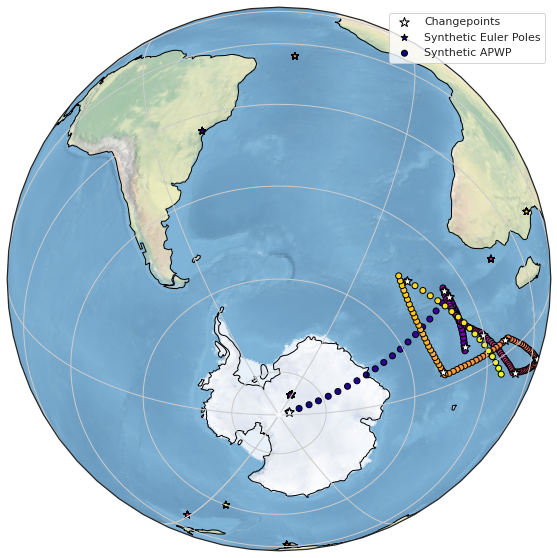

In [28]:
fig = plt.figure(figsize=(10,10))

proj = ccrs.Orthographic(-30, -60)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

ax.scatter(x = np.degrees(APWP_LatLong[:,1]), y = np.degrees(APWP_LatLong[:,0]),
           c = np.array(range(len(APWP_LatLong))), cmap="plasma", 
           Label = "Synthetic APWP", edgecolors='black',
           transform=ccrs.PlateCarree())

ax.scatter(x = np.degrees(EPs_LatLong[:,1]), y = np.degrees(EPs_LatLong[:,0]),
           c = np.array(range(len(APWP_LatLong))), cmap="plasma", 
           Label = "Synthetic Euler Poles", edgecolors='black', marker ="*", s = 50,
           transform=ccrs.PlateCarree())

ax.scatter(x = np.degrees(changepoints_latlong[:,1]), y = np.degrees(changepoints_latlong[:,0]),
            
           Label = "Changepoints", marker ="*", s = 100, color = "white" , edgecolor='black',
           transform=ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))

plt.show()

## Step 2: Computing the adjacency matrix
Takes up to 15 minutes (for 200 PPs)

In [7]:
%%time
n_min = 3   # minumum period of years with constant Euler pole
n_max = 30  # maximum period of years with constant Euler pole
n_iter = 1  # number of iterations for different initial conditions in the optimization method

Adj_matrix = np.full((N, N), np.inf)
matrix_eps = np.full((N, N), np.inf, dtype=object)

for i in range(N):
    
    for j in range(i + n_min, i + n_max + 1):
        
        if j >= N:
            continue
            
        # We define the loss function from zero since it has the PP inside the function        
        X = apwp_df[i:j+1][['PP_x', 'PP_y', 'PP_z']].to_numpy()
                        
        # If the first and last point are too close in relation to the other points of the segments, this indicates
        # the presence two different EPs with overlapping segments moving in opposite directions
        pp_i, pp_f = X[0], X[-1]
        
        path_distance = GCD_cartesian(pp_i, pp_f)
        max_dist = np.max([GCD_cartesian(X[k], X[m]) for m in range(X.shape[0]) for k in range(m+1,X.shape[0])])
        if path_distance < 0.8 * max_dist:
            continue
             
        def loss (v):
            theta, phi, varphi = v[0], v[1], v[2]                   
            res = 0
            pole = spherical2cartesian([theta, phi])
            for k in range(X.shape[0]):
                res += ( np.arccos( np.dot( X[k,:], pole)) - varphi ) ** 2        
            return res
        
        
        initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(-np.pi/2, np.pi / 2)] #set up random initial guess        
        best = np.inf        
        for _ in range(n_iter): 
            
            optimum_tmp = minimize(loss, x0 = np.array(initialGuess), method = "CG", options = {'gtol': 1E-10})
            
            initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(-np.pi/2, np.pi / 2)]           
            
            if optimum_tmp.fun < best: 
                optimum = optimum_tmp
                best = optimum_tmp.fun                
                
        Adj_matrix[i,j] = optimum.fun
        matrix_eps[i,j] = spherical2cartesian([optimum.x[0], optimum.x[1]])

CPU times: user 10min 13s, sys: 177 ms, total: 10min 13s
Wall time: 10min 13s


We can make a heatmap to visualize the adjacency matrix, so we can see how favorable/unfavorable are certain change points. 

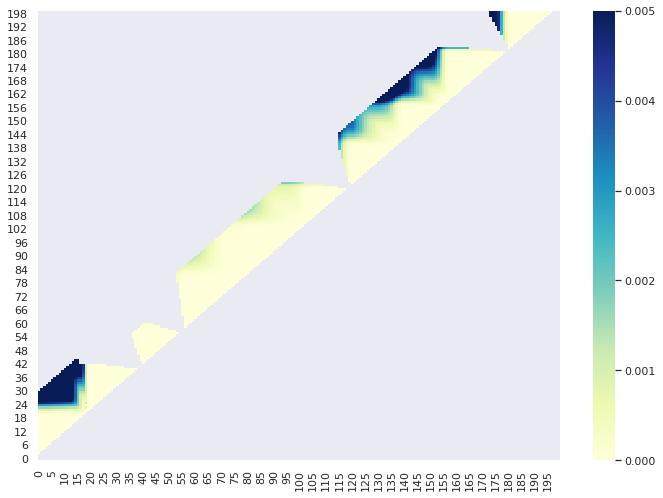

In [8]:
from matplotlib.colors import LogNorm
Adj_matrix_df = pd.DataFrame(Adj_matrix.transpose())

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(Adj_matrix_df, vmin=0, vmax=0.005, cmap="YlGnBu", robust=True).invert_yaxis()

We then proceed to calculate the APWP changepoints from the shortest path. This is done by using the Dijkstra algorithm, which is computationally effective to finding the shortest path in a weighted graph. We calculate this for different choices of the regularization lambda parameter. 

In [9]:
N_lamb = 1000
all_lamb_log = np.linspace(-8, 1, N_lamb)
all_lamb = 10 ** all_lamb_log

Tree = np.full((N, N_lamb), 0)
Tree_lamb = []
Tree_age = []

all_cost, all_nsegments = [], []

for i, lamb in enumerate(all_lamb):    
    
    changepoints, dist_matrix = get_changepoints(Adj_matrix, reg=lamb)
    
    for x in changepoints:
        Tree[x, i] = 1
        Tree_lamb.append(np.log10(lamb))
        Tree_age.append(apwp_df.i[x])
    
    loss_reg = lamb * (len(changepoints)+1)
    loss = dist_matrix[0,-1]
    loss1 = loss - loss_reg
    
    all_nsegments.append(len(changepoints)+1)
    all_cost.append(loss1)

We can plot the location of the different changepoints versus increasing values of the hypterparameter $\lambda$. This gives us a cascade of the location of changepoints for each $\lambda$ and how they decrease in number as we increase the model complexity. Smaller values of lambda are associated to a larger model complexity, i.e., more change-points. 

Text(0.5, 0, '$\\lambda$ (10^)')

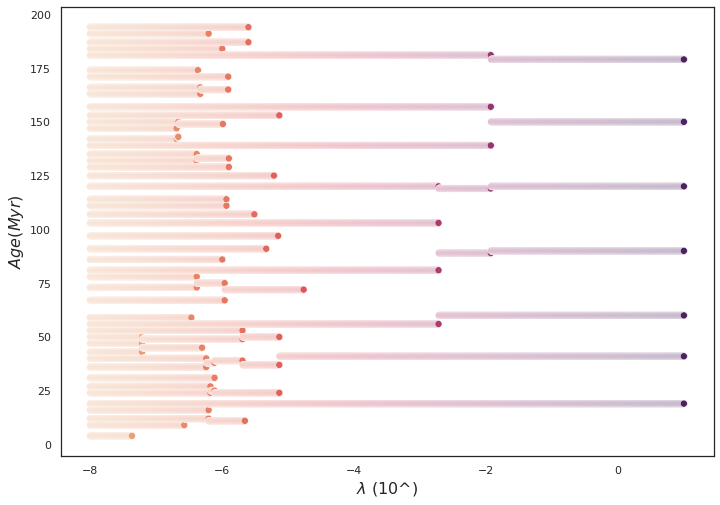

In [10]:
sns.set_style("white")

sns.scatterplot(x = Tree_lamb , y = Tree_age, hue=Tree_lamb, palette= "flare", s=50, legend=False)

plt.ylabel('$Age (Myr)$', size = 16)
plt.xlabel('$\lambda$ (10^)', size = 16)

## Step 3: Elbow plot

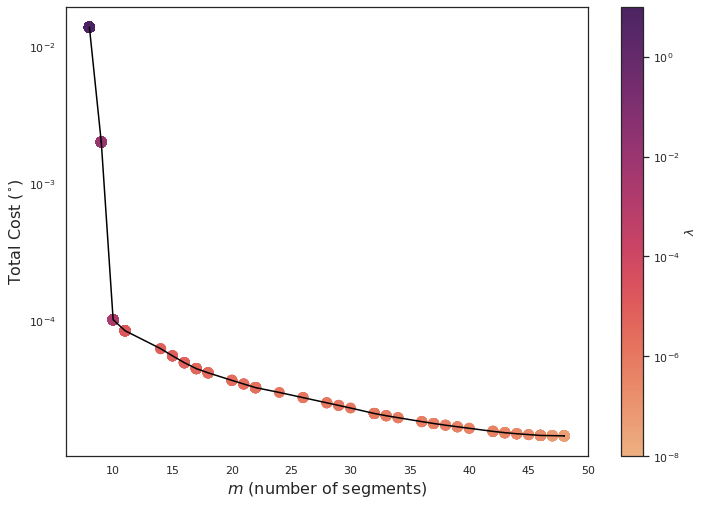

In [11]:
from matplotlib.colors import LogNorm

sns.set_style("white")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(all_nsegments, all_cost, color="black")
plt.scatter(all_nsegments, all_cost, c = all_lamb, s= 100, cmap = "flare", norm=LogNorm())

plt.ylabel('Total Cost ($^{\circ}$)', size = 16)
plt.xlabel('$m$ (number of segments)', size = 16)

plt.yscale('log')
plt.colorbar(label = '$\lambda$')

plt.show()

Now, we pick the value of lambda for which we observe the elbow in the plot

In [12]:
lamb_opt = all_lamb[np.max(np.where(np.array(all_nsegments) == 9))]

changepoints, dist_matrix = get_changepoints(Adj_matrix, reg=0.001)
changepoints, lamb_opt

([19, 41, 56, 81, 103, 120, 139, 157, 181], 0.011805165285688056)

In [13]:
apwp_df[apwp_df['changepoint'] == True]

,i,PP_x,PP_y,PP_z,changepoint,EP_x,EP_y,EP_z,omega
0,0,0.028732,0.025296,-0.999267,True,0.609333,-0.677967,-0.411186,0.043540
20,20,0.599496,0.375945,-0.706591,True,-0.097513,0.001644,0.995233,0.017490
41,41,0.452617,0.527300,-0.719091,True,0.091365,-0.005971,-0.995800,0.026079
57,57,0.614643,0.345622,-0.709055,True,0.714524,0.487911,-0.501397,0.041550
82,82,0.494232,0.582117,-0.645658,True,0.660896,0.007485,0.750440,0.014661
104,104,0.330947,0.811354,-0.481849,True,0.987436,0.062666,0.145060,0.018438
121,121,0.302343,0.920533,-0.247402,True,-0.628876,0.395808,-0.669217,0.024262
140,140,0.467243,0.692157,-0.550094,True,-0.890780,0.446754,0.083202,0.019422
158,158,0.358727,0.489982,-0.794501,True,-0.784631,-0.598256,0.162613,0.026325
182,182,0.611814,0.189604,-0.767941,True,0.495520,-0.060498,0.866487,0.042079


## Step 4: Statistics for the comparison of true kinematics with those inferred

Function that generates a DataFrame in which we put the inversion parameters

In [14]:
def EPdf(APWP, matrix_eps, changepoints):
    '''Creates a DataFrame with the inverted EPs
    input: APWP is a list of cartesian coordinates, 
    matrix_eps is the matrix with the inverted Euler Poles (matrix_eps[i:j] is the
    inverted EP for the segment ti - tj).
    
    output: Dataframe with cartesian coordinates of the inverted euler poles for each 1-Myr step'''
    EPs = []
    omegas = []
    tmp = 0
    
    for i in range(len(matrix_eps)):                          
        
        if i <= changepoints[0]:
            EP = matrix_eps[0, changepoints[tmp]]
            omega = StageEP(EP, APWP[0:changepoints[tmp]]) / len(APWP[0:changepoints[tmp]])
        elif i >= changepoints[-1]:
            EP = matrix_eps[changepoints[-1], len(matrix_eps)-1]
            omega = StageEP(EP, APWP[changepoints[-1]: len(matrix_eps)-1]) / len(APWP[changepoints[-1]: len(matrix_eps)-1])
        else:
            EP = matrix_eps[changepoints[tmp], changepoints[tmp+1]]
            omega = StageEP(EP, APWP[changepoints[tmp]: changepoints[tmp+1]]) / len(APWP[changepoints[tmp]: changepoints[tmp+1]])
            if (i) > (changepoints[tmp + 1]-1): tmp += 1 
                
        EPs.append(EP)
        omegas.append(omega)
    
    EPs = np.array(EPs)
    omegas = np.array(omegas)
    
    dictionary = { 'EP_x_inv': EPs[:,0],
                   'EP_y_inv': EPs[:,1],
                   'EP_z_inv': EPs[:,2],
                   'omega_inv': omegas,
                  }
    
    df = pd.DataFrame(dictionary)            
       
    return df                                                         

Creating the DataFrame for the inversion

In [15]:
apwp_complete = apwp_df
EP_inversion = EPdf(APWP, matrix_eps, changepoints)
apwp_complete = apwp_complete.join(EP_inversion)

Function that measures the discrepancy of points at a given latitude, after rotating with the whole sequence of inverted poles

In [16]:
def points_misfit(apwp_complete, lat):
    
    GCD_list = []
    for _,i in apwp_complete.iterrows():
        
        if _ == 0: point, point_inv = spherical2cartesian([lat, 0]), spherical2cartesian([lat, 0])
              
        r = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
        r_inv = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))

        point = r.apply(np.array(point))
        point_inv = r_inv.apply(np.array(point_inv))
        
        GCD_list.append(GCD_cartesian(point, point_inv))
    
    apwp_complete['Point' + str(np.round(np.degrees(lat),0).astype(int))] = GCD_list
    
    return apwp_complete

In [17]:
GCD_list = []

for _,i in apwp_complete.iterrows():

    if _ == 0: point, point_inv = spherical2cartesian([lat, 0]), spherical2cartesian([lat, 0])

    r = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
    r_inv = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))

    point = r.apply(np.array(point))
    point_inv = r_inv.apply(np.array(point_inv))

    GCD_list.append(GCD_cartesian(point, point_inv))

Misfit between an APWP and the one we obtained from the inversion of EPs

In [18]:
def apwp_misfit(apwp_complete):
    
    PP_x, PP_y, PP_z = [], [], []

    for _,i in apwp_complete.iterrows():

        if _ == 0: pp = [0,0,-1]  

        r = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))  
        pp = r.apply(np.array(pp))   
        pp_x, pp_y, pp_z = pp[0], pp[1], pp[2]    
        PP_x.append(pp_x) 
        PP_y.append(pp_y) 
        PP_z.append(pp_z) 

    apwp_complete['PP_x_inv'] = PP_x    
    apwp_complete['PP_y_inv'] = PP_y   
    apwp_complete['PP_z_inv'] = PP_z   
    apwp_complete['PPs_Misfit'] = [GCD_cartesian([i.PP_x, i.PP_y, i.PP_z], [i.PP_x_inv, i.PP_y_inv, i.PP_z_inv]) for _, i in apwp_complete.iterrows()]
    
    return apwp_complete

Calculate the total reconstruction pole for each time (known)

In [19]:
def total_rotation_poles(apwp_complete):
    
    TR_x, TR_y, TR_z, TR_omega = [], [], [], []
    TR_x_inv, TR_y_inv, TR_z_inv, TR_omega_inv = [], [], [], []
        
    for _,i in apwp_complete.iterrows():   
        if _ == 0: 
            ep = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))                    
            TR_omega.append(ep.magnitude())
            TR_x.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
        else:
            ep_tmp = rotation.from_rotvec(i.omega * np.array([i.EP_x, i.EP_y, i.EP_z]))
            ep = rotation.from_matrix(np.dot(ep_tmp.as_matrix(), ep.as_matrix()))
            TR_omega.append(ep.magnitude())  
            TR_x.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
            
    apwp_complete['TR_x'] = TR_x
    apwp_complete['TR_y'] = TR_y
    apwp_complete['TR_z'] = TR_z
    apwp_complete['TR_omega'] = TR_omega
    
    return apwp_complete

In [20]:
def total_rotation_poles_inv(apwp_complete):
        
    TR_x_inv, TR_y_inv, TR_z_inv, TR_omega_inv = [], [], [], []
        
    for _,i in apwp_complete.iterrows():   
        if _ == 0: 
            ep = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))                    
            TR_omega_inv.append(ep.magnitude())
            TR_x_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
        else:
            ep_tmp = rotation.from_rotvec(i.omega_inv * np.array([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv]))
            ep = rotation.from_matrix(np.dot(ep_tmp.as_matrix(),ep.as_matrix()))
            TR_omega_inv.append(ep.magnitude())
            TR_x_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[0])
            TR_y_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[1])
            TR_z_inv.append((ep.as_rotvec() / np.linalg.norm(ep.as_rotvec()))[2])
            
    apwp_complete['TR_x_inv'] = TR_x_inv
    apwp_complete['TR_y_inv'] = TR_y_inv
    apwp_complete['TR_z_inv'] = TR_z_inv
    apwp_complete['TR_omega_inv'] = TR_omega_inv
    
    return apwp_complete

Comparison of true kinematics with those inferred from the proposed methodoly. 
- Euler-pole misfit represents the geodesic distance between Euler poles associated with true and inferred stage Euler vectors.
- angular-velocity misfit if the difference between angular velocities of true and inferred stage Euler vectors

In [26]:
apwp_complete['EP_Misfit'] = [GCD_cartesian([i.EP_x_inv, i.EP_y_inv, i.EP_z_inv],[i.EP_x, i.EP_y, i.EP_z]) for _,i in apwp_complete.iterrows()]
apwp_complete['AngVel_Misfit'] = [(np.abs(i.omega) - np.abs(i.omega_inv)) for _,i in apwp_complete.iterrows()]
apwp_complete['EP_Misfit_corr'] = [(np.pi - i.EP_Misfit) if i.EP_Misfit > (np.pi / 2) else i.EP_Misfit for _,i in apwp_complete.iterrows()]

In [22]:
apwp_complete.head()

,i,PP_x,PP_y,PP_z,changepoint,EP_x,EP_y,EP_z,omega,EP_x_inv,EP_y_inv,EP_z_inv,omega_inv,EP_Misfit,AngVel_Misfit,EP_Misfit_corr
0,0,0.028732,0.025296,-0.999267,True,0.609333,-0.677967,-0.411186,0.04354,0.611375,-0.67346,-0.415539,0.041343,0.006591,0.002197,0.006591
1,1,0.059192,0.051281,-0.996929,False,0.609333,-0.677967,-0.411186,0.04354,0.611375,-0.67346,-0.415539,0.041343,0.006591,0.002197,0.006591
2,2,0.089346,0.076156,-0.993085,False,0.609333,-0.677967,-0.411186,0.04354,0.611375,-0.67346,-0.415539,0.041343,0.006591,0.002197,0.006591
3,3,0.118313,0.099210,-0.988008,False,0.609333,-0.677967,-0.411186,0.04354,0.611375,-0.67346,-0.415539,0.041343,0.006591,0.002197,0.006591
4,4,0.149665,0.122843,-0.981076,False,0.609333,-0.677967,-0.411186,0.04354,0.611375,-0.67346,-0.415539,0.041343,0.006591,0.002197,0.006591


First, we plot the geodetic distantce between the known and the inferred EP position

(0.0, 200.0)

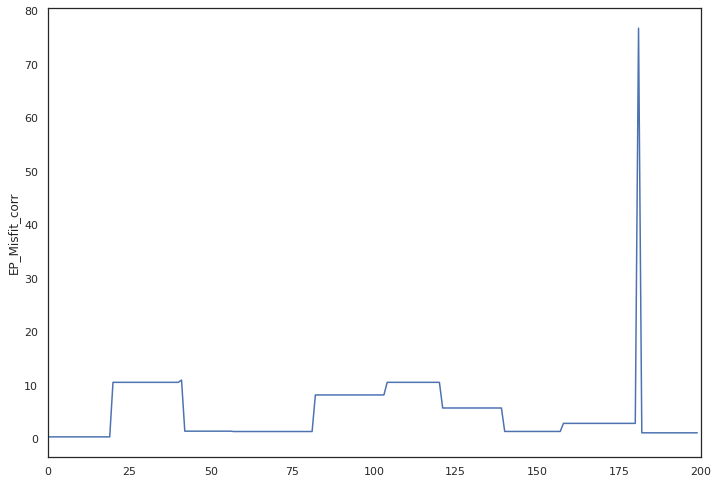

In [23]:
sns.lineplot( x = apwp_complete.index, y = apwp_complete['EP_Misfit_corr'] * 180 / np.pi)
plt.xlim(0,200)